# Toy Hidden Markov Model

Below I implement a version of a hidden Markov model, based loosely on the description chapter 9 of Shütze and Manning 1992. The motivation here is that I found this section to be useful but a little bit opaque -- creating the simplest possible object that could produce a diagram of the calculations for the forward and backward aglorithms seemed like a good way to clarify things for myself.

One major difference between the model I implement below and the examples in Shütze and Manning is that the model below is a state emission model, where the probability of each emission symbol at time t is entirely determined by the hidden state of the model at time t. Shütze and Manning discuss examples where the probability of each emission symbol is a function of the transition from the state a t-1 to the state at t.  It just seemed like an easier place to start. 

A crucial reason that this is a toy model is that I don't have anything in place to handle underflow, so this model will only be accurate for a little while before the probabilites get too small for Python to handle.  Also, the main use in NLP for HMMs is POS tagging, but that's going to require a step of Baysian calculations that undermines the principle of making a really simple model, so instead I use this to model a different set of opaquely-generated symbols: predicting the probability of sequences of noises my kitten, Ozzie, makes.   

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import networkx.drawing
from networkx.drawing.nx_pydot import write_dot
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline


The HMM model is implemented as an object that takes several arguments: 

`states`: the set of hidden states that the model transitions between

`symbols`: the set of visible symbols that the model emits

`transitions`: the probability of transiting from one state to another: this should be a square 2d matrix where each dimension is equal to the number of states.

`emissions`: the probability of emitting a particular symbol, given a particular state.

`starting probability`: the probability that, for each state, the system at time t=0 will be in that state.

In [2]:
class HMM:
    import numpy as np
    import pandas as pd
    
    def __init__(self, states = None, symbols = None, transitions = None, emissions = None, starting_probab = None):
        self.states = states
        self.symbols = symbols
        self.transitions = transitions
        self.emissions = emissions
        self.starting_probab = starting_probab
        
    #set the list of hidden states    
    def set_states(self, value):
        if isinstance(value,list) or value is None:
            self._states = value
        else:
            raise ValueError("'states' must be a list of states.")
            
    #return the list of states
    def get_states(self):
        return self._states
    
    #set the list of emitted symbols
    def set_symbols(self, value):
        if isinstance(value, list) or value is None:
            self._symbols = value
        else:
            raise ValueError("'symbols' must be a list of symbols.")
        
    #return the list of emitted symbols
    def get_symbols(self):
        return self._symbols
    
    #set the matrix of transition probabilities
    def set_transitions(self, value):
        if isinstance(value, np.ndarray) or isinstance(value, pd.DataFrame):
            if self.states is not None:
                if value.ndim == 2:
                    if len(self.states) == value.shape[0]:
                        if len(self.states) == value.shape[1]:
                            self._transitions = value
                        else:
                            raise ValueError("'transitions' has the wrong number of columns")
                    else:
                        raise ValueError("'transitions' has the wrong number of rows")
                else:
                    raise ValueError("'transitions' should be a 2-dimensional numpy array")
        elif value is None:
            self._transitions = value
        else:
            raise ValueError("'transitions' must be a numpy array.")
        
    #return a DataFrame of transition probabilities
    def get_transitions(self):
        col_labels = ["to " + x for x in self._states]
        row_labels = ["from " + x for x in self._states]
        return pd.DataFrame(self._transitions, columns=col_labels, index = row_labels)
    
    
    #set the matrix of emission probabilities
    def set_emissions(self, value):
        if isinstance(value, np.ndarray):
            self._emissions = value
            
        elif value is None:
            self._emissions = value
        else:
            raise ValueError("Emissions must be a numpy array")
    
    #return a DataFrame of emission probabilities
    def get_emissions(self):
        return pd.DataFrame(self._emissions, index=self._states, columns = self._symbols)
    
    #set a list of starting probabilities
    def set_starting_probab(self, value):
        if isinstance(value, np.ndarray) or isinstance(value,list):
            self._starting_probab = value
        elif value is None:
            self._starting_probab = value
        else:
            raise ValueError("Starting probabilities must be a numpy array")
            
    #return the list of starting probabilities
    def get_starting_probab(self):
        return pd.DataFrame(self._starting_probab,index=self._states)
    
    #set list of observed symbols
    def set_observed(self, value):
        if isinstance(value, list):
            if set(value).issubset(set(self._symbols)):
                self._observed = value
        else:
            raise ValueError("The observed sequence of symbols must be comprised only of the HMM's emission symbols.")
            
    #return list of observed symbols       
    def get_observed(self):
        return self._observed
    
 #   def draw_state_model(self):
 #       if self._states is not None:
 #           dot = Digraph(comment='State diagram')
 #           for i, state in enumerate(self._states):
 #               dot.node(state)
 #               if self._transitions is not None:
 #                   for j,state2 in enumerate(self._states):
 #                       dot.edge(state,state2,label=str(self._transitions[i][j]))
 #           return(dot)
 #       else:
 #           raise ValueError("No states available in model.")
            
            
            
    #calculate the probability of a given sequence based on the forward algorithm
    def _forward_algorithm(self):
        #check that all of the requisite arguments are there
        if not any(elem is None for elem in [self._states, self._starting_probab, self._transitions, self._emissions, self._observed]):
            #create a matrix that will hold the fw algorithm up to each time t
            forward_matrix = np.zeros((len(self._observed),len(self._states)))   
            #create a matrix that will hold the probability of transitioning between states for
            #each timestep
            transition_probability_matrix = np.zeros((len(self._observed)-1,len(self._states),len(self._states)))   
            #loop through each time step
            for i, symbol in enumerate(self._observed):
                #calculate the first step based on the starting probabilities
                if i == 0:
                    forward_matrix[0] = self._emissions[:,self._symbols.index(self._observed[0])] * self._starting_probab
                #calculate the subsequent steps based on the transitions matrix    
                elif i > 0:
                    previous_step = forward_matrix[i-1]
                    for j, state in enumerate(self._states):
                        step_transition_prob = np.sum(previous_step * self._transitions[:,j])
                        #calculate the probability of transitioning from the current state to each other state
                        for k, state in enumerate(self._states):
                            transition_probability_matrix[i-1][j][k] = previous_step[j] * self._transitions[k,j]
                        forward_matrix[i][j] = self._emissions[j][self._symbols.index(self._observed[i])] * step_transition_prob
        return(forward_matrix,transition_probability_matrix,sum(forward_matrix[-1]))

    #return the probabilty of the observed sequence
    def forward_algorithm(self):
        fw,tm,prob = self._forward_algorithm()
        print(f"Probability of seeing the sequence {self._observed}: {prob:.2}")
        #return fw,tm,prob
            
    #return a little chart of the observed sequence
    def visualize_forward_algorithm(self):
        if self._states is not None and self._transitions is not None and self._observed is not None:
            fw,tm,prob = self._forward_algorithm()
            dot = Digraph(comment='Forward algorithm diagram', engine="neato")
            edges = []
            for j, symbol in enumerate(self._observed):
                index_j = str(j)
                label_text = 't = '+str(j)+'\n'+symbol
                label_position = str(6*j)+',0!'
                dot.node(index_j, label_text, shape='plain', pos=label_position)
                for i, state in enumerate(self._states):
                    index_i = str(i)+' '+str(j)
                    position = str(6*j)+','+str(2*i+1)+'!'
                    label = state +f"\n\nP({symbol}|{', '.join(self._observed[:j])},{state})\na = "+ f"{fw[j][i]:.3f}"
                    dot.node(index_i, label, pos=position)
                    if j < len(self._observed)-1:
                        for k,_ in enumerate(self._states):
                            transition_probability = tm[j-1][i][k]
                            dot.edge(index_i, str(k)+' '+str(j+1), f"a*P({state}|{self._states[k]})=\n{transition_probability:.2}")
            dot.edges(edges)            
            #print(fw)
            print(edges)
            return(dot)
            
            
            
   
            
        
  #  def backward_algorithm(self):
  #      if not any(elem is None for elem in [self._states, self._symbols, self._transitions, self._emissions, self._observed]):
  #          backward_algorithm = np.zeros((len(self._observed)+1,len(self._states)))
  #          for i, symbol in enumerate(self._observed):
  #              if i == 0:
  #                  backward_algorithm[0] = [1 for elem in self._states]
  #              else:
  #                  bw = backward_algorithm[i - 1] 
  #                  for j,state in enumerate(self._states):
  #                      prob = bw * self._transitions[j] * self._emissions[:,self._symbols.index(self._observed[-i])]
  #                      backward_algorithm[i][j] = np.sum(prob)
  #          final_bw = backward_algorithm[i]
  #          backward_algorithm[i+1] = final_bw * self._starting_probab * self._emissions[:,self._symbols.index(self._observed[0])]  
  #          return backward_algorithm
        
    
        
    
    states = property(get_states, set_states)
    symbols = property(get_symbols, set_symbols)
    transitions = property(get_transitions, set_transitions)
    emissions = property(get_emissions, set_emissions)
    starting_probab = property(get_starting_probab, set_starting_probab)
    observed = property(get_observed, set_observed)

Modeling the probability that Ozzie will emit the symbols "meow", "chirp", "meow", based on the likelihood that he'll produce these sounds when he's in one of two states: hungry or playful.

In [3]:
hmm = HMM()
hmm.states = ["hungry","playful"]
hmm.symbols = ["meow","chirp","purr"]
hmm.starting_probab = [.3, .7]
hmm.transitions = np.array([[.4,.6],[.8,.2]])
hmm.emissions = np.array([[.6,.4,.2],[.1,.4,.5]])
hmm.observed = ["meow","chirp","meow"]

In [4]:
hmm.states

['hungry', 'playful']

In [5]:
hmm.symbols

['meow', 'chirp', 'purr']

In [6]:
hmm.starting_probab

,0
hungry,0.3
playful,0.7


In [7]:
hmm.transitions

,to hungry,to playful
from hungry,0.4,0.6
from playful,0.8,0.2


In [8]:
hmm.emissions

,meow,chirp,purr
hungry,0.6,0.4,0.2
playful,0.1,0.4,0.5


In [9]:
hmm.forward_algorithm()

Probability of seeing the sequence ['meow', 'chirp', 'meow']: 0.04


Sort of a messy diagram, but: at t=0, Ozzie emits the "meow" symbol.  When he's in the playful state, there's a 7% chance that he'll emit the "meow" symbol, and when he's in the hungry state, there's an 18% chance that he'll emit the "meow" symbol. 

At this point, we can get the overall probability of the "meow" symbol at time t=0 by summing the probability of this symbol for both states, which would be 25%. 

To calculate the probability of the emission sequence "meow", "chirp", we need to multiply each of these probabilities from t=0 by the probability of transitioning from the relevant state to each other state, and then sum the results. At time t=1, we can calculate the probability of the emission sequence so far, "meow", "chirp" by adding together the proability that we're in the playful state at t=1 and the symbol emitted was a meow with the same situation in the hungry state, and the resulting probability is 10%.  

The same calculations go into the final step, where the total probability of hearing the observed sequence is 4%.

[]


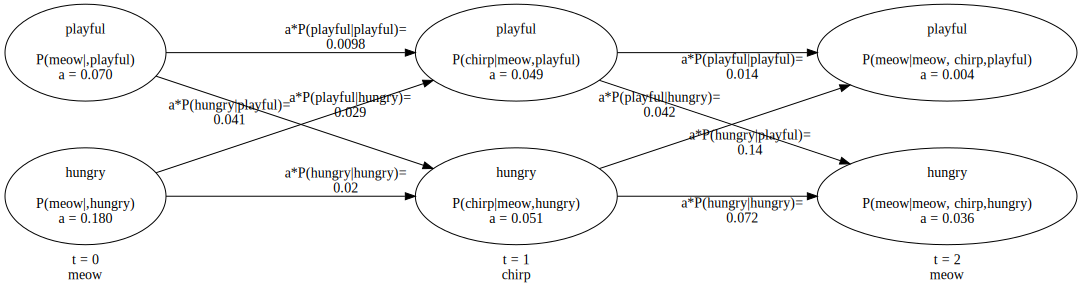

In [10]:
hmm.visualize_forward_algorithm()